# Natural Language Processing with Disaster Tweets

https://www.kaggle.com/competitions/nlp-getting-started

Kaggle Profile: https://www.kaggle.com/remyflatt

Achives:
    Test Score of Score: 0.81366

References:
    https://www.tensorflow.org/text/tutorials/classify_text_with_bert

We'll create multiple different models and use the best performing one to generate predictions on the test dataset.

## Import Libraries

In [72]:
import numpy as np
import pandas as pd
import tensorflow as tf 

import matplotlib.pyplot as plt
import missingno
import seaborn as sns

from sklearn.model_selection import train_test_split

from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

import tensorflow_text as text 
import tensorflow_hub as hub

import re
import string

### Install dependencies for BERT

In [73]:
pip install -q tf-models-official==2.11.0

Note: you may need to restart the kernel to use updated packages.


In [74]:
# Required for BERT
from official.nlp import optimization

## Import Helper Functions

In [75]:
# Import helper functions from my github
!wget https://raw.githubusercontent.com/remz99/Kaggle/main/helper_functions.py

from helper_functions import *

--2023-03-16 00:46:01--  https://raw.githubusercontent.com/remz99/Kaggle/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3344 (3.3K) [text/plain]
Saving to: ‘helper_functions.py.19’

helper_functions.py 100%[===================>]   3.27K  --.-KB/s    in 0s      

2023-03-16 00:46:01 (27.5 MB/s) - ‘helper_functions.py.19’ saved [3344/3344]



## Load Data

In [76]:
DATASET_PATH = '/kaggle/input/nlp-getting-started'

train_df = pd.read_csv(DATASET_PATH + '/train.csv')
test_df  = pd.read_csv(DATASET_PATH + '/test.csv')

In [77]:
# How many samples total?
print(f"Total training samples: {len(train_df)}")
print(f"Total test samples: {len(test_df)}")
print(f"Total samples: {len(train_df) + len(test_df)}")

Total training samples: 7613
Total test samples: 3263
Total samples: 10876


In [78]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


0    4342
1    3271
Name: target, dtype: int64


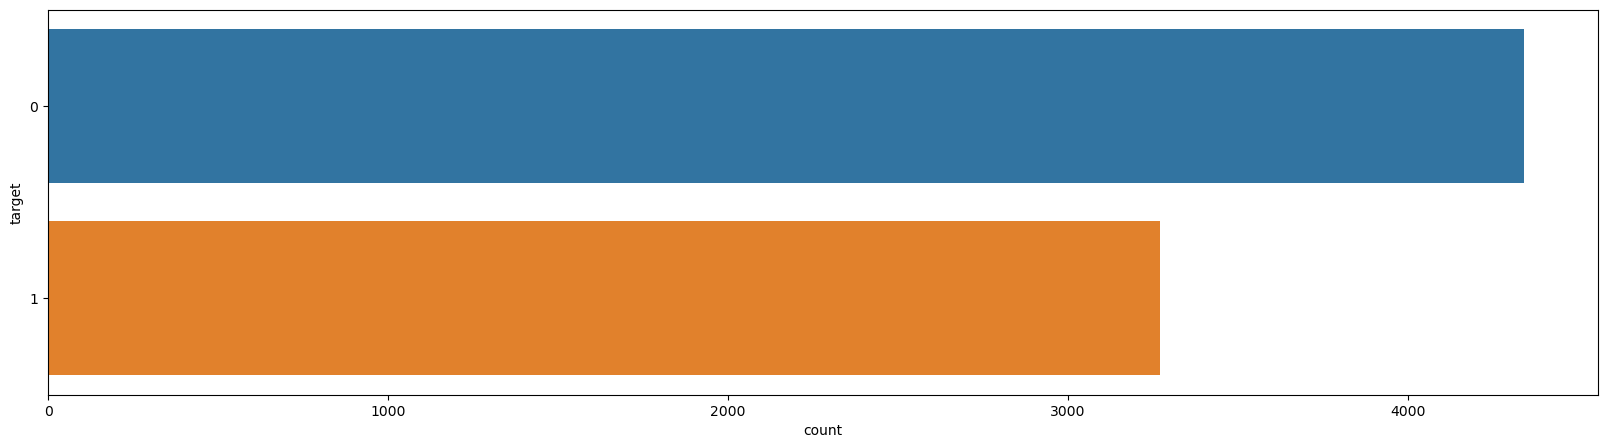

In [79]:
# Plot distribution of target
print(train_df.target.value_counts())

plt.figure(figsize=(20, 5))
sns.countplot(y="target", data=train_df);

In [80]:
# Find rows in train data with NA values
train_df.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [81]:
# Check Datatypes
train_df.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

## Data Clean Up

We'll remove any urls, html, emoji and punctuation from the tweets

In [82]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"
                           u"\U0001F300-\U0001F5FF"
                           u"\U0001F680-\U0001F6FF"
                           u"\U0001F1E0-\U0001F1FF"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)


In [83]:
train_df.text = train_df.text.apply(lambda x : remove_URL(x))
train_df.text = train_df.text.apply(lambda x : remove_html(x))
train_df.text = train_df.text.apply(lambda x : remove_emoji(x))
train_df.text = train_df.text.apply(lambda x : remove_punct(x))

In [84]:
test_df.text = test_df.text.apply(lambda x : remove_URL(x))
test_df.text = test_df.text.apply(lambda x : remove_html(x))
test_df.text = test_df.text.apply(lambda x : remove_emoji(x))
test_df.text = test_df.text.apply(lambda x : remove_punct(x))

In [85]:
# We're just going to ignore the location and keyword columns
train_df.drop(columns=['id', 'location', 'keyword'], inplace=True)
test_df.drop(columns=['location', 'keyword'], inplace=True)


## Create Test & Validation splits

In [86]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df.text,
                                                                            train_df.target,
                                                                            test_size=0.2,
                                                                            random_state=42)

In [87]:
# Just use the defaults for the text vectorization
text_vectorizer = tf.keras.layers.TextVectorization()
text_vectorizer.adapt(train_sentences)

In [88]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens

print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") 
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 15726
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['0106', '010217', '010156', '005225', '0011']


In [89]:
# find what character length covers 95% of sequences
char_lens = [len(sentence) for sentence in train_sentences]
max_length = int(np.percentile(char_lens, 95))

max_vocab_length = len(words_in_vocab)

## Model Setup

In [90]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels)).cache().shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE) 
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels)).cache().batch(32).prefetch(tf.data.AUTOTUNE) 

In [91]:
MAX_EPOCHS = 25
CHECKPOINT_PATH = '/kaggle/working/checkpoints/'

# Baseline Model

Create a basic model with an average pooling layer

In [92]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")

x = text_vectorizer(inputs)

x = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             embeddings_initializer="uniform",
                             input_length=max_length)(x) 

# lower the dimensionality of the embedding (try running the model without this layer and see what happens)
x = layers.GlobalAveragePooling1D()(x)

# create the output layer, want binary outputs so use sigmoid activation
outputs = layers.Dense(1, activation="sigmoid")(x)

model_1 = tf.keras.Model(inputs, outputs, name="model_1") 

# Compile model
model_1.compile(
  loss="binary_crossentropy",
  optimizer=tf.keras.optimizers.Adam(),
  metrics=["accuracy"]
)

model_1_history = model_1.fit(
  train_dataset,
  epochs=MAX_EPOCHS,
  steps_per_epoch=len(train_dataset),
  validation_data=val_dataset,
  validation_steps=len(val_dataset),
  callbacks=[
    create_checkpoint_callback(CHECKPOINT_PATH + model_1.name),
    create_early_stopping_callback()
  ]
)

model_1.load_weights(CHECKPOINT_PATH + model_1.name)
model_1.evaluate(val_dataset)


Epoch 1/25
191/191 [==============================] - ETA: 0s - loss: 0.6451 - accuracy: 0.6266
Epoch 1: val_accuracy improved from -inf to 0.75378, saving model to /kaggle/working/checkpoints/model_1
191/191 [==============================] - 10s 48ms/step - loss: 0.6451 - accuracy: 0.6266 - val_loss: 0.5850 - val_accuracy: 0.7538
Epoch 2/25
191/191 [==============================] - ETA: 0s - loss: 0.4972 - accuracy: 0.8057
Epoch 2: val_accuracy improved from 0.75378 to 0.80039, saving model to /kaggle/working/checkpoints/model_1
191/191 [==============================] - 2s 12ms/step - loss: 0.4972 - accuracy: 0.8057 - val_loss: 0.4917 - val_accuracy: 0.8004
Epoch 3/25
191/191 [==============================] - ETA: 0s - loss: 0.3796 - accuracy: 0.8614
Epoch 3: val_accuracy improved from 0.80039 to 0.80302, saving model to /kaggle/working/checkpoints/model_1
191/191 [==============================] - 2s 9ms/step - loss: 0.3796 - accuracy: 0.8614 - val_loss: 0.4612 - val_accuracy: 0.

[0.46120840311050415, 0.8030203580856323]

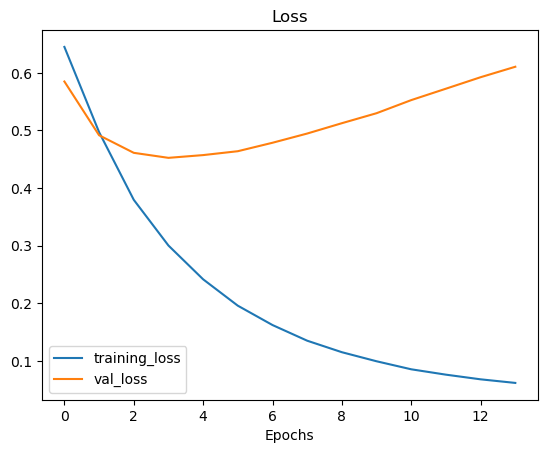

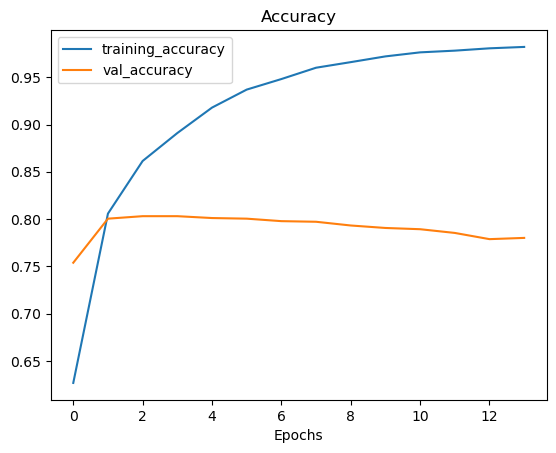

In [93]:
plot_loss_curves(model_1_history)

### LSTM Model

Create a model with two LSTM layers and a Dropout Layer

In [94]:
inputs = layers.Input(shape=(1,), dtype="string")

x = text_vectorizer(inputs)

x = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             embeddings_initializer="uniform",
                             input_length=max_length,
                             name="embedding_1")(x) 

x = layers.LSTM(64, return_sequences=True)(x) 
x = layers.Dropout(0.2)(x)
x = layers.LSTM(64)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model_2 = tf.keras.Model(inputs, outputs, name="model_2") 

model_2.compile(
  loss="binary_crossentropy",
  optimizer=tf.keras.optimizers.Adam(),
  metrics=["accuracy"]
)

model_2_history = model_2.fit(
  train_dataset,
  epochs=MAX_EPOCHS,
  steps_per_epoch=len(train_dataset),
  validation_data=val_dataset,
  validation_steps=len(val_dataset),
  callbacks=[
    create_checkpoint_callback(CHECKPOINT_PATH + model_2.name),
    create_early_stopping_callback()
  ]
)

model_2.load_weights(CHECKPOINT_PATH + model_2.name)
model_2.evaluate(val_dataset)


Epoch 1/25
191/191 [==============================] - ETA: 0s - loss: 0.5369 - accuracy: 0.7256
Epoch 1: val_accuracy improved from -inf to 0.78201, saving model to /kaggle/working/checkpoints/model_2
191/191 [==============================] - 15s 56ms/step - loss: 0.5369 - accuracy: 0.7256 - val_loss: 0.4958 - val_accuracy: 0.7820
Epoch 2/25
191/191 [==============================] - ETA: 0s - loss: 0.2945 - accuracy: 0.8869
Epoch 2: val_accuracy improved from 0.78201 to 0.78332, saving model to /kaggle/working/checkpoints/model_2
191/191 [==============================] - 4s 20ms/step - loss: 0.2945 - accuracy: 0.8869 - val_loss: 0.5122 - val_accuracy: 0.7833
Epoch 3/25
191/191 [==============================] - ETA: 0s - loss: 0.1645 - accuracy: 0.9455
Epoch 3: val_accuracy did not improve from 0.78332
191/191 [==============================] - 2s 12ms/step - loss: 0.1645 - accuracy: 0.9455 - val_loss: 0.7309 - val_accuracy: 0.7754
Epoch 4/25
186/191 [============================>.]

[0.5121600031852722, 0.7833223938941956]

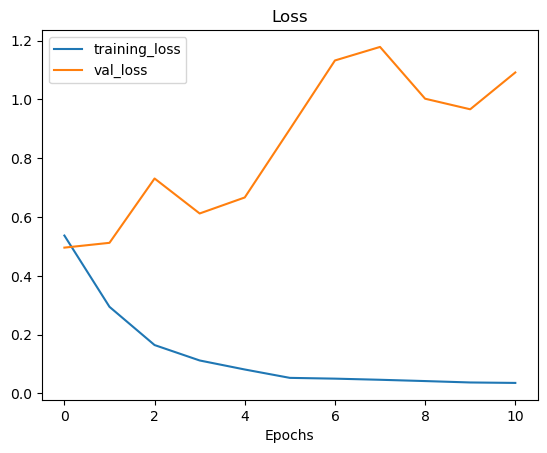

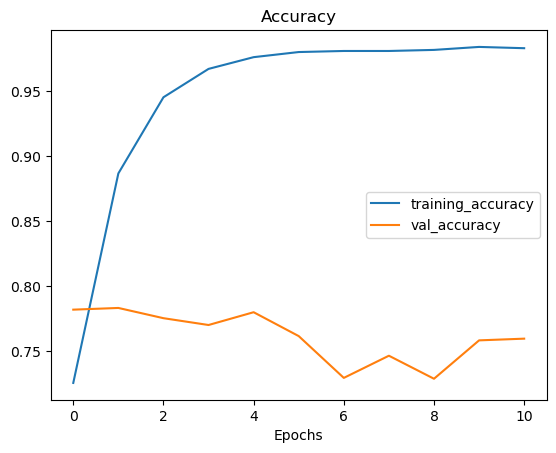

In [95]:
plot_loss_curves(model_2_history)

## Bidirectional model

Create a Bidirectional model with LSTM layers

In [96]:
inputs = layers.Input(shape=(1,), dtype="string")

x = text_vectorizer(inputs)

x = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             embeddings_initializer="uniform",
                             input_length=max_length,
                             name="embedding_1")(x) 

x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Dropout(0.2)(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model_3 = tf.keras.Model(inputs, outputs, name="model_3") 

model_3.compile(
  loss="binary_crossentropy",
  optimizer=tf.keras.optimizers.Adam(),
  metrics=["accuracy"]
)

model_3_history = model_3.fit(
  train_dataset,
  epochs=MAX_EPOCHS,
  steps_per_epoch=len(train_dataset),
  validation_data=val_dataset,
  validation_steps=len(val_dataset),
  callbacks=[
    create_checkpoint_callback(CHECKPOINT_PATH + model_3.name),
    create_early_stopping_callback()
  ]
)

model_3.load_weights(CHECKPOINT_PATH + model_3.name)
model_3.evaluate(val_dataset)


Epoch 1/25
191/191 [==============================] - ETA: 0s - loss: 0.5219 - accuracy: 0.7401
Epoch 1: val_accuracy improved from -inf to 0.81418, saving model to /kaggle/working/checkpoints/model_3
191/191 [==============================] - 24s 73ms/step - loss: 0.5219 - accuracy: 0.7401 - val_loss: 0.4314 - val_accuracy: 0.8142
Epoch 2/25
191/191 [==============================] - ETA: 0s - loss: 0.2567 - accuracy: 0.9018
Epoch 2: val_accuracy did not improve from 0.81418
191/191 [==============================] - 6s 31ms/step - loss: 0.2567 - accuracy: 0.9018 - val_loss: 0.4926 - val_accuracy: 0.7846
Epoch 3/25
191/191 [==============================] - ETA: 0s - loss: 0.1400 - accuracy: 0.9540
Epoch 3: val_accuracy did not improve from 0.81418
191/191 [==============================] - 4s 22ms/step - loss: 0.1400 - accuracy: 0.9540 - val_loss: 0.5880 - val_accuracy: 0.7722
Epoch 4/25
191/191 [==============================] - ETA: 0s - loss: 0.0970 - accuracy: 0.9695
Epoch 4: val

[0.4314288794994354, 0.8141825199127197]

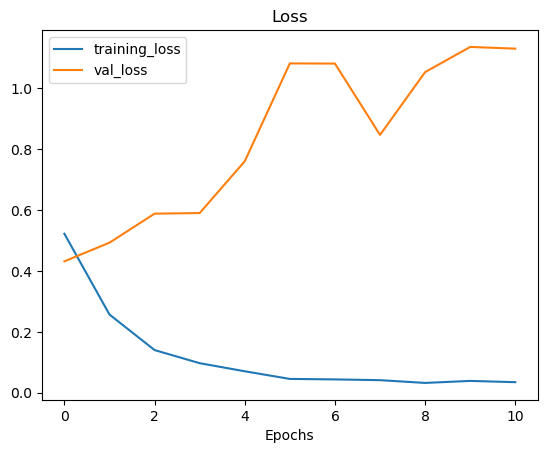

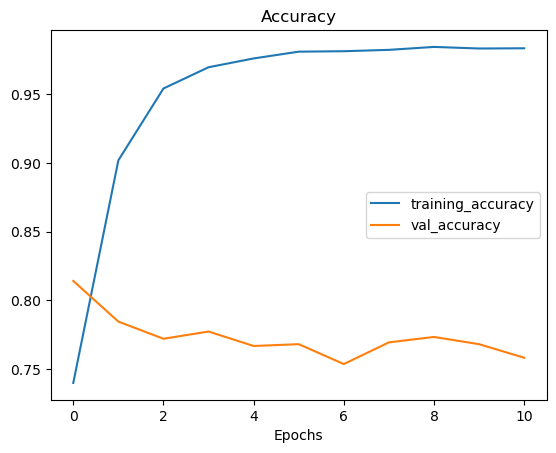

In [97]:
plot_loss_curves(model_3_history)

## Bidirectional with USE embedding layer

Us the Universal Sentence Encoder embedding layer with a bidirectional model from model_3

In [98]:
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-large/5",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False, 
                                        name="USE")

inputs = layers.Input(shape=(), dtype="string", name="input_layer")

x = sentence_encoder_layer(inputs)

x = layers.Reshape((1, 512), input_shape=(None, 512))(x)

x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Dropout(0.2)(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)

outputs = tf.keras.layers.Dense(1, activation = 'sigmoid',name = 'output_layer')(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4") 

model_4.compile(
  loss="binary_crossentropy",
  optimizer=tf.keras.optimizers.Adam(),
  metrics=["accuracy"]
)

model_4.summary()

model_4_history = model_4.fit(
  train_dataset,
  epochs=MAX_EPOCHS,
  steps_per_epoch=len(train_dataset),
  validation_data=val_dataset,
  validation_steps=len(val_dataset),
  callbacks=[
    create_checkpoint_callback(CHECKPOINT_PATH + model_4.name),
    create_early_stopping_callback()
  ]
)


model_4.load_weights(CHECKPOINT_PATH + model_4.name)
model_4.evaluate(val_dataset)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None,)]                 0         
                                                                 
 USE (KerasLayer)            (None, 512)               147354880 
                                                                 
 reshape_1 (Reshape)         (None, 1, 512)            0         
                                                                 
 bidirectional_9 (Bidirectio  (None, 1, 128)           295424    
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 1, 128)            0         
                                                                 
 bidirectional_10 (Bidirecti  (None, 1, 128)           98816     
 onal)                                                     

[0.4125949442386627, 0.8332238793373108]

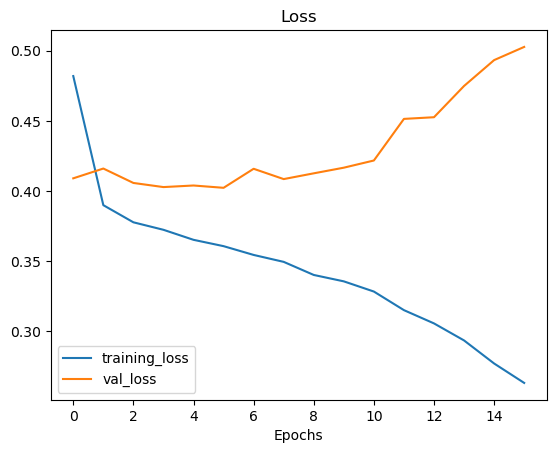

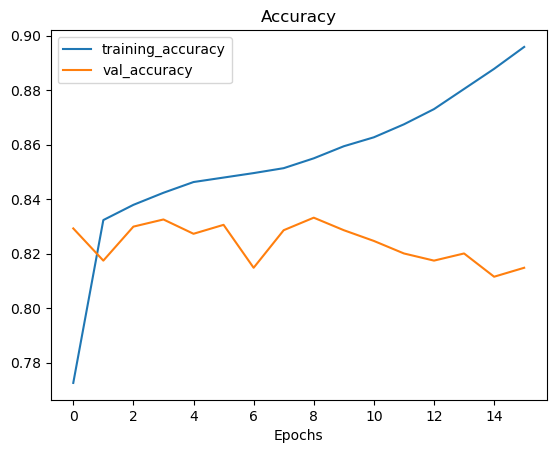

In [99]:
plot_loss_curves(model_4_history)

## BERT

From https://www.tensorflow.org/text/tutorials/classify_text_with_bert

In [100]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

def build_bert_model(name):
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.2)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net, name=name)

model_5 = build_bert_model('model_5')


In [101]:
# This example uses the adamw optimizer - refer to tutorial for info
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

steps_per_epoch = 6090  # tf.data.experimental.cardinality(dataset)
num_train_steps = steps_per_epoch * MAX_EPOCHS
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')


In [102]:
model_5.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=metrics)

In [103]:
model_5_history = model_5.fit(
    train_dataset, 
    epochs=MAX_EPOCHS,
    steps_per_epoch=len(train_dataset),
    validation_data=val_dataset,
    validation_steps=len(val_dataset),
    callbacks=[
      create_checkpoint_callback(CHECKPOINT_PATH + model_5.name, monitor='val_binary_accuracy'),
      create_early_stopping_callback(patience=10)
    ])
          
    
model_5.load_weights(CHECKPOINT_PATH + model_5.name)
model_5.evaluate(val_dataset)

Epoch 1/25
191/191 [==============================] - ETA: 0s - loss: 5.4293 - binary_accuracy: 0.5575
Epoch 1: val_binary_accuracy improved from -inf to 0.57452, saving model to /kaggle/working/checkpoints/model_5
191/191 [==============================] - 45s 200ms/step - loss: 5.4293 - binary_accuracy: 0.5575 - val_loss: 4.9881 - val_binary_accuracy: 0.5745
Epoch 2/25
191/191 [==============================] - ETA: 0s - loss: 4.4364 - binary_accuracy: 0.5608
Epoch 2: val_binary_accuracy improved from 0.57452 to 0.63099, saving model to /kaggle/working/checkpoints/model_5
191/191 [==============================] - 38s 200ms/step - loss: 4.4364 - binary_accuracy: 0.5608 - val_loss: 2.5958 - val_binary_accuracy: 0.6310
Epoch 3/25
191/191 [==============================] - ETA: 0s - loss: 3.0432 - binary_accuracy: 0.5989
Epoch 3: val_binary_accuracy improved from 0.63099 to 0.70256, saving model to /kaggle/working/checkpoints/model_5
191/191 [==============================] - 37s 196ms/

[1.997776746749878, 0.8246881365776062]

## Evaluate all the models

In [104]:
compare_model_metrics(
    models=[model_1,model_2, model_3, model_4],
    val_features=val_sentences,
    val_labels=val_labels
)

48/48 [==============================] - 13s 43ms/step


,accuracy,precision,recall,f1
model_2,78.332239,0.782816,0.783322,0.783002
model_1,80.302035,0.802538,0.803020,0.801577
model_3,81.418253,0.817910,0.814183,0.810727
model_4,83.322390,0.835099,0.833224,0.831094


In [105]:
results = {}

for model in [model_1, model_2, model_3, model_4, model_5]:
    results[model.name] = model.evaluate(val_dataset)

pd.DataFrame.from_dict(results).transpose().rename(columns={0: "Loss", 1: "Accuracy"})


48/48 [==============================] - 5s 108ms/step - loss: 1.9978 - binary_accuracy: 0.8247


,Loss,Accuracy
model_1,0.461208,0.803020
model_2,0.512160,0.783322
model_3,0.431429,0.814183
model_4,0.412595,0.833224
model_5,1.997777,0.824688


## Create Kaggle Submission

While model_4 has the better accuracy on the validation set, model_5 performs slightly better on the test dataset.

In [106]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_df.text).cache().batch(32).prefetch(tf.data.AUTOTUNE) 

# Create predictions with BERT model
preds = model_5.predict(test_dataset)
preds = tf.sigmoid(preds)
test_df['target'] = np.round(preds).astype('int64')

test_df.to_csv(
    "/kaggle/working/submission.csv", 
    columns=['id', 'target'], 
    index=False
)

102/102 [==============================] - 10s 94ms/step
